# Lab 4: Spam Classifier on Ingested Data
##### ML Productions
##### Dr. Nowling

## Library Import

In [1]:
import glob
import json
import numpy as np
import os
import pandas as pd
import io
import boto3
import yaml
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression  
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.metrics import roc_curve
from sklearn.decomposition import TruncatedSVD
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import pyspark
from minio import Minio
from minio.error import S3Error
import scipy
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn import svm


## Importing Data

The data type of each colum is an object since each colum is comprised of string objects.

In [2]:
target = boto3.resource('s3',
    endpoint_url="http://127.0.0.1:9000",
    aws_access_key_id="minioadmin",
    aws_secret_access_key="minioadmin",
    aws_session_token=None,
    config=boto3.session.Config(signature_version='s3v4'),
    verify=False
)
client = boto3.client('s3',
    endpoint_url="http://127.0.0.1:9000",
    aws_access_key_id="minioadmin",
    aws_secret_access_key="minioadmin",
    aws_session_token=None,
    config=boto3.session.Config(signature_version='s3v4'),
    verify=False
)

In [3]:
#Load the bucket training-data using the boto3 library
bucket = target.Bucket('training-data')
#load all the objects in the bucket
for obj in bucket.objects.all():
    #Convert the json file into a json object
    #The json file ocnsists of 
    key = obj.key
    rows = []
    if "json" in key:
        obj = obj.get()
        #print(key)
        #print(obj)
        bytes_buffer = io.BytesIO()
        client.download_fileobj('training-data', key, bytes_buffer)   
        byte_value = bytes_buffer.getvalue()
        str_values = byte_value.decode().split('\n')
        i=0
        while i < len(str_values):
            #print(i)
            str_v = str_values[i]
            #print(str_v)
            if len(str_v) > 0: #Last line is empty
                rows.append(json.loads(str_v))
            i+=1

In [4]:
#Convert the json object into a pandas dataframe
df = pd.DataFrame(rows)
#Print the first 5 rows of the dataframe
df = df.set_index('email_id')
df.head()

,to,body,from,subject,label
email_id,,,,,
5,<the00@plg.uwaterloo.ca>,authentic viagra\n\nMega authenticV I A G R A...,"""Sheila Crenshaw"" <7stocknews@tractionmarketin...",authentic viagra,spam
1,the00@speedy.uwaterloo.ca,\n\n\n\n\n\n\nDo you feel the pressure to perf...,"""Tomas Jacobs"" <RickyAmes@aol.com>","Generic Cialis, branded quality@",spam
2,debian-mirrors@lists.debian.org,"Hi, i've just updated from the gulus and I che...",Yan Morin <yan.morin@savoirfairelinux.com>,Typo in /debian/README,ham
41,gnitpick@speedy.uwaterloo.ca,"\n\nHello,\n\nOur staff have been trying to co...","""Healy, Latonya"" <Wright3Y@strategies4capital....",Mortgage Approved!,spam
3,the00@speedy.uwaterloo.ca,\n\n\n\n\n\n\nDo you feel the pressure to perf...,"""Tomas Jacobs"" <RickyAmes@aol.com>","Generic Cialis, branded quality@",spam


## Experiments

### Common Functions

In [5]:
def train_test_val_split(X, y, min_df=10):
    #Split the Data into Train, Test and Validation
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

    #Downsample the larger class
    #Get the indices of the minority class
    minority_class_indices = np.where(y_train == 0)[0]
    #Get the indices of the majority class
    majority_class_indices = np.where(y_train == 1)[0]
    #Downsample the majority class
    majority_class_indices_downsampled = np.random.choice(majority_class_indices, len(minority_class_indices), replace=False)
    
    #Combine the majority and minority class indices
    downsampled_indices = np.concatenate([minority_class_indices, majority_class_indices_downsampled])
    #Downsample the training data
    X_train = X_train[downsampled_indices]
    y_train = y_train[downsampled_indices]

    #Return the training, test and validation data
    return X_train, X_test, X_val, y_train, y_test, y_val

def process_data(X_train, y_train, X_test, y_test, X_val, y_val, min_df=10):
    #Use CountVectorizer to convert the text into a vector
    vectorizer = CountVectorizer(min_df=min_df)
    X_train = vectorizer.fit_transform(X_train)
    X_test = vectorizer.transform(X_test)
    X_val = vectorizer.transform(X_val)
   
    #Print the Shape of the training, test and validation data
    print("Shape of filtered Training Data: ", X_train.shape)
    print("Shape of Test Data: ", X_test.shape)
    print("Shape of Validation Data: ", X_val.shape)
    return X_train, y_train, X_test, y_test, X_val, y_val

def plot_confusion_matrix(y_val, y_pred):
    cm = confusion_matrix(y_val, y_pred)
    print(cm)
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    classNames = ['Spam','Ham']
    plt.title('Confusion Matrix')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    tick_marks = np.arange(len(classNames))
    plt.xticks(tick_marks, classNames, rotation=45)
    plt.yticks(tick_marks, classNames)
    s = [['TN','FP'], ['FN', 'TP']]
    for i in range(2):
        for j in range(2):
            plt.text(j,i, str(s[i][j])+" = "+str(cm[i][j]))
    plt.show()

def print_scores(y_val, y_pred):
    matrix = confusion_matrix(y_val, y_pred)
    tp = matrix[1][1]
    tn = matrix[0][0]
    fp = matrix[0][1]
    fn = matrix[1][0]

    acc = (tp+tn)/(tp+tn+fn+fp)
    prec = (tp)/(tp+fp)
    recall = (tp)/(tp+fn)

    print('Accuracy:', acc)
    print('Precision:', prec)
    print('Recall:', recall)

    return acc, prec, recall

### Raw Data Used for All Experiments

In [6]:
y = df['label'].to_numpy()
X = df['body'].to_numpy()
#Convert y into a binary vector
y = np.where(y == 'ham', 0, 1)
#Get the training, test and validation data
X_train, X_test, X_val, y_train, y_test, y_val = train_test_val_split(X, y)

### Experiment 1: Logistic Regression and Count Vectorizer with min_df = 10

These are the parameters set in the first lab.

Shape of filtered Training Data:  (4132, 5553)
Shape of Test Data:  (2161, 5553)
Shape of Validation Data:  (1729, 5553)
Accuracy: 0.9595141700404858
Precision: 0.9536163522012578
Recall: 0.9910130718954249


c:\class_files\ml_prod\cs4981_ml_productions\.venv\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


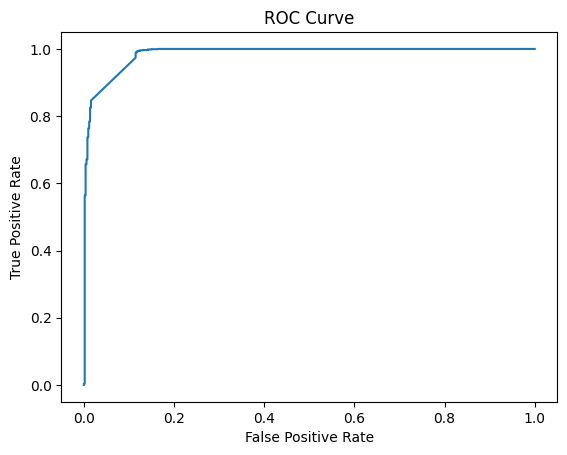

In [7]:
#Process the data
X_train1, y_train1, X_test1, y_test1, X_val1, y_val1 = process_data(X_train, y_train, X_test, y_test, X_val, y_val)
#Create a Logistic Regression Model
model = LogisticRegression()
#Train the model
model.fit(X_train1, y_train1)
#Get the predictions
y_pred = model.predict(X_val1)
acc1, prec1, recall1 = print_scores(y_val1, y_pred)
#Get the probabilities
y_pred_prob = model.predict_proba(X_val1)[:,1]
#Get the ROC curve
fpr, tpr, thresholds = roc_curve(y_val1, y_pred_prob)
#Plot the ROC curve
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

[[ 446   59]
 [  11 1213]]


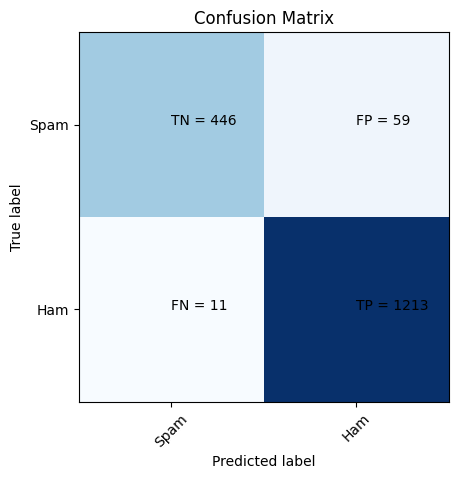

In [8]:
plot_confusion_matrix(y_val1, y_pred)

### Experiment 2: Logistic Regression and Count Vectorizer with min_df = 20


Shape of filtered Training Data:  (4132, 3233)
Shape of Test Data:  (2161, 3233)
Shape of Validation Data:  (1729, 3233)
Accuracy: 0.9589358010410642
Precision: 0.9542947202521671
Recall: 0.9893790849673203


c:\class_files\ml_prod\cs4981_ml_productions\.venv\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


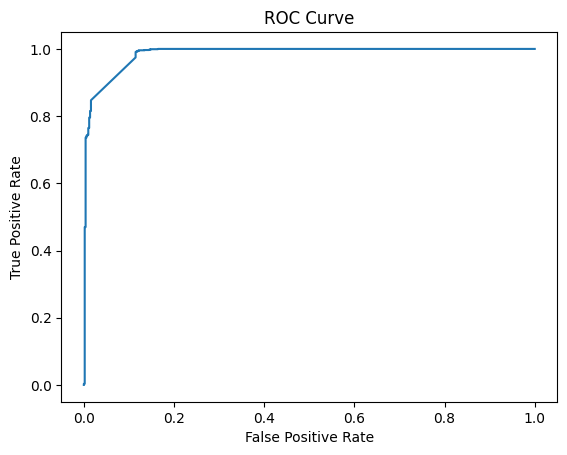

In [9]:
#Process the data
X_train2, y_train2, X_test2, y_test2, X_val2, y_val2 = process_data(X_train, y_train, X_test, y_test, X_val, y_val, min_df=20)
#Create a Logistic Regression Model
model = LogisticRegression()
#Train the model
model.fit(X_train2, y_train2)
#Get the predictions
y_pred = model.predict(X_val2)
#Get the probabilities
y_pred_prob = model.predict_proba(X_val2)[:,1]
acc2, prec2, recall2 = print_scores(y_val2, y_pred)
#Get the ROC curve
fpr, tpr, thresholds = roc_curve(y_val2, y_pred_prob)
#Plot the ROC curve
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

[[ 447   58]
 [  13 1211]]


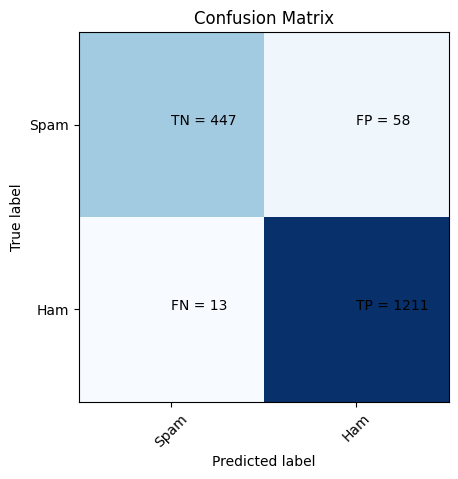

In [10]:
plot_confusion_matrix(y_val2, y_pred)

### Experiment 3: Support Vector Machine and Count Vectorizer with min_df = 5

Shape of filtered Training Data:  (4132, 9630)
Shape of Test Data:  (2161, 9630)
Shape of Validation Data:  (1729, 9630)
Accuracy: 0.9583574320416426
Precision: 0.9528301886792453
Recall: 0.9901960784313726


c:\class_files\ml_prod\cs4981_ml_productions\.venv\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


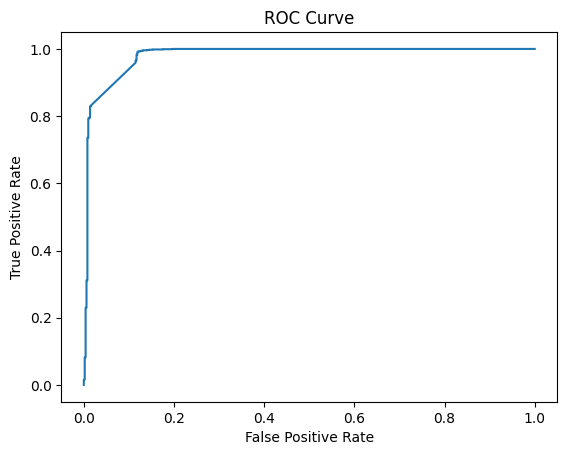

In [11]:
#Process the data
X_train3, y_train3, X_test3, y_test3, X_val3, y_val3 = process_data(X_train, y_train, X_test, y_test, X_val, y_val, min_df=5)
#Create a Support Vector Machine Model
model = svm.LinearSVC()
#Train the model
model.fit(X_train3, y_train3)
#Get the predictions
y_pred = model.predict(X_val3)
#Get the probabilities
y_pred_prob = model.decision_function(X_val3)
acc3, prec3, recall3 = print_scores(y_val3, y_pred)
#Get the ROC curve
fpr, tpr, thresholds = roc_curve(y_val3, y_pred_prob)
#Plot the ROC curve
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

[[ 445   60]
 [  12 1212]]


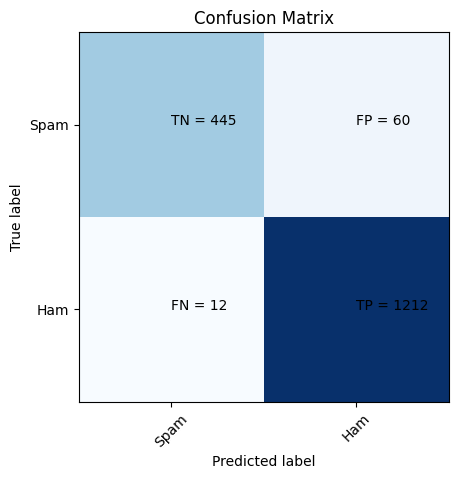

In [12]:
plot_confusion_matrix(y_val3, y_pred)

## Conclusion

The Logistic Regression model with a min_df of 10 appears to work best for this classification.

### Output the Parameters of the Best Model

In [13]:
#Output parameters and metrics for the best model as a json file
experiment_results = {
    'parameters': {
        'model': 'Logistic Regression',
        'min_df': 10,
    },
    'metrics': {
        'accuracy': acc1,
        'precision': prec1,
        'recall': recall1,
    }
}
with open('output.json', 'w') as f:
    json.dump(output, f)